In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [8]:
n =  5228 #novel number
t = 'Search_Sky'#novel name
s = 6 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [9]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [10]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [11]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [14]:
df_novel.head()

,0
0,"Often I sit alone at night, staring with the e..."
1,"And when, ultimately, that _final_ develo..."
2,"-- _She_, Silver Library Edition, p. 277."
3,"DEDICATION My dear Lang, The appointed years..."
4,"how many of them--are gone by, leaving Ayesha ..."


Create the wrd_length and total_char columns.

In [15]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [16]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [17]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [18]:
df_novel.head()

,0,wrd_length,total_char
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67


Create syllable count column

In [19]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [20]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [21]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [22]:
df_novel['syl_count'] = syl_count_arr

In [23]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178,"[2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, ..."
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381,"[1, 1, 5, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27,"[0, 2, 3, 3, 0, 0]"
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41,"[4, 1, 2, 1, 1, 2, 2, 2]"
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67,"[1, 2, 1, 1, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 2]"


In [24]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [25]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [26]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [27]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [28]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Create cluster dataframe - remove columns that can't be used

In [29]:
df_cluster = df_novel.drop('wrd_length', 1)

In [30]:
df_cluster = df_cluster.drop('syl_count', 1)

In [31]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"Often I sit alone at night, staring with the e...",178,57.0,0.300000
1,"And when, ultimately, that _final_ develo...",381,125.0,0.049074
2,"-- _She_, Silver Library Edition, p. 277.",27,8.0,0.000000
3,"DEDICATION My dear Lang, The appointed years...",41,15.0,0.000000
4,"how many of them--are gone by, leaving Ayesha ...",67,24.0,0.425000


Create 20 clusters on scaled data

In [32]:
X = df_cluster.drop(0, axis=1)

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [35]:
df_cluster_20 = df_cluster.copy()

In [36]:
df_cluster_20['cluster'] = km.labels_

In [37]:
df_cluster_20.head()

,0,total_char,syl_sum,sentiment,cluster
0,"Often I sit alone at night, staring with the e...",178,57.0,0.300000,18
1,"And when, ultimately, that _final_ develo...",381,125.0,0.049074,6
2,"-- _She_, Silver Library Edition, p. 277.",27,8.0,0.000000,0
3,"DEDICATION My dear Lang, The appointed years...",41,15.0,0.000000,13
4,"how many of them--are gone by, leaving Ayesha ...",67,24.0,0.425000,17


In [38]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"Often I sit alone at night, staring with the e...",178,57.0,0.300000
1,"And when, ultimately, that _final_ develo...",381,125.0,0.049074
2,"-- _She_, Silver Library Edition, p. 277.",27,8.0,0.000000
3,"DEDICATION My dear Lang, The appointed years...",41,15.0,0.000000
4,"how many of them--are gone by, leaving Ayesha ...",67,24.0,0.425000


In [39]:
df_cluster_20.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,17.372530,5.508893,-0.001006
1,190.220779,59.675325,-0.348284
2,136.862069,42.948276,0.597765
3,121.253138,37.658996,0.002287
4,67.899281,21.352518,0.207234
5,77.317073,24.170732,-0.829288
6,318.960784,100.882353,0.069742
7,37.083871,11.522581,0.454317
8,230.105263,72.513158,0.055988


In [40]:
centers = df_cluster_20.groupby('cluster').mean()

Create Scatter plot 

In [41]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

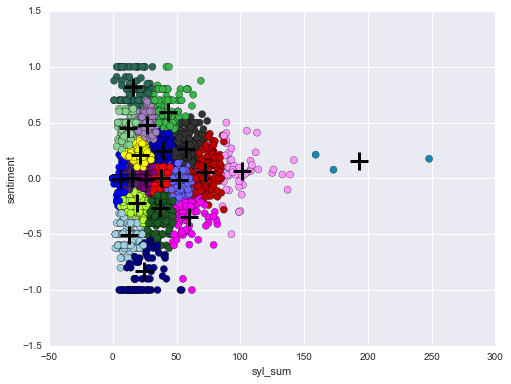

In [42]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster_20.syl_sum, df_cluster_20.sentiment, c=colors[df_cluster_20.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Add cluster_20 to original dataframe

In [43]:
df_novel['cluster_20'] = df_cluster_20['cluster']

In [44]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178,"[2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, ...",57.0,0.300000,18
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381,"[1, 1, 5, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",125.0,0.049074,6
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27,"[0, 2, 3, 3, 0, 0]",8.0,0.000000,0
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41,"[4, 1, 2, 1, 1, 2, 2, 2]",15.0,0.000000,13
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67,"[1, 2, 1, 1, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 2]",24.0,0.425000,17


Create 3 clusters

In [45]:
df_cluster_3 = df_cluster.copy()

In [46]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment
0,"Often I sit alone at night, staring with the e...",178,57.0,0.300000
1,"And when, ultimately, that _final_ develo...",381,125.0,0.049074
2,"-- _She_, Silver Library Edition, p. 277.",27,8.0,0.000000
3,"DEDICATION My dear Lang, The appointed years...",41,15.0,0.000000
4,"how many of them--are gone by, leaving Ayesha ...",67,24.0,0.425000


In [47]:
X = df_cluster_3.drop(0, axis=1)

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [50]:
df_cluster_3['cluster'] = km.labels_

In [51]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,49.047317,15.310892,-0.061181
1,163.416355,51.139201,0.014194
2,83.684337,26.216867,0.446946


In [52]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,"Often I sit alone at night, staring with the e...",178,57.0,0.300000,1
1,"And when, ultimately, that _final_ develo...",381,125.0,0.049074,1
2,"-- _She_, Silver Library Edition, p. 277.",27,8.0,0.000000,0
3,"DEDICATION My dear Lang, The appointed years...",41,15.0,0.000000,0
4,"how many of them--are gone by, leaving Ayesha ...",67,24.0,0.425000,2


Add cludter_3 to original dataframe

In [53]:
df_novel['cluster_3_syl'] = df_cluster_3['cluster']

In [54]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178,"[2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, ...",57.0,0.300000,18,1
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381,"[1, 1, 5, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",125.0,0.049074,6,1
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27,"[0, 2, 3, 3, 0, 0]",8.0,0.000000,0,0
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41,"[4, 1, 2, 1, 1, 2, 2, 2]",15.0,0.000000,13,0
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67,"[1, 2, 1, 1, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 2]",24.0,0.425000,17,2


Create 3 Clusters with no syl_sum

In [55]:
df_cluster_3no_syl = df_cluster.copy()

In [56]:
df_cluster_3no_syl = df_cluster.drop('syl_sum', 1)

In [57]:
X = df_cluster_3no_syl.drop(0, axis=1)

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [60]:
df_cluster_3no_syl['cluster'] = km.labels_

In [61]:
df_cluster_3no_syl.head()

,0,total_char,sentiment,cluster
0,"Often I sit alone at night, staring with the e...",178,0.300000,1
1,"And when, ultimately, that _final_ develo...",381,0.049074,1
2,"-- _She_, Silver Library Edition, p. 277.",27,0.000000,0
3,"DEDICATION My dear Lang, The appointed years...",41,0.000000,0
4,"how many of them--are gone by, leaving Ayesha ...",67,0.425000,2


In [62]:
df_cluster_3no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,49.887980,-0.064265
1,163.574122,0.008750
2,87.375723,0.452976


Add cluster_3no_syl to original dataframe

In [63]:
df_novel['cluster_3no_syl'] = df_cluster_3no_syl['cluster']

In [64]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178,"[2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, ...",57.0,0.300000,18,1,1
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381,"[1, 1, 5, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",125.0,0.049074,6,1,1
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27,"[0, 2, 3, 3, 0, 0]",8.0,0.000000,0,0,0
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41,"[4, 1, 2, 1, 1, 2, 2, 2]",15.0,0.000000,13,0,0
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67,"[1, 2, 1, 1, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 2]",24.0,0.425000,17,2,2


Create 5 Clusters

In [65]:
df_cluster_5 = df_cluster.copy()

In [66]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment
0,"Often I sit alone at night, staring with the e...",178,57.0,0.300000
1,"And when, ultimately, that _final_ develo...",381,125.0,0.049074
2,"-- _She_, Silver Library Edition, p. 277.",27,8.0,0.000000
3,"DEDICATION My dear Lang, The appointed years...",41,15.0,0.000000
4,"how many of them--are gone by, leaving Ayesha ...",67,24.0,0.425000


In [67]:
X = df_cluster_5.drop(0, axis=1)

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [70]:
df_cluster_5['cluster'] = km.labels_

In [71]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,36.788194,11.539497,-0.002450
1,71.517442,22.351744,-0.535475
2,81.053272,25.456621,0.503695
3,115.151685,35.834582,0.003292
4,205.658754,64.526706,0.081146


Add cluster_5 to original dataframe

In [72]:
df_novel['cluster_5'] = df_cluster_5['cluster']

In [73]:
df_novel.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178,"[2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, ...",57.0,0.300000,18,1,1,4
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381,"[1, 1, 5, 1, 2, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",125.0,0.049074,6,1,1,4
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27,"[0, 2, 3, 3, 0, 0]",8.0,0.000000,0,0,0,0
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41,"[4, 1, 2, 1, 1, 2, 2, 2]",15.0,0.000000,13,0,0,0
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67,"[1, 2, 1, 1, 1, 1, 1, 3, 2, 3, 1, 2, 1, 2, 2]",24.0,0.425000,17,2,2,2


Write files to csv

In [74]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [75]:
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [76]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
0,"Often I sit alone at night, staring with the e...","[5, 1, 3, 5, 2, 5, 7, 4, 3, 4, 2, 2, 4, 4, 3, ...",178,[2 1 1 2 1 1 2 1 1 0 1 1 1 2 1 2 1 2 1 1 3 1 1...,57.0,0.300000,18,1,1,4
1,"And when, ultimately, that _final_ develo...","[3, 4, 10, 4, 5, 11, 6, 2, 1, 4, 2, 5, 2, 4, 3...",381,[1 1 5 1 2 4 2 1 1 1 1 1 1 1 1 1 2 1 4 1 1 1 1...,125.0,0.049074,6,1,1,4
2,"-- _She_, Silver Library Edition, p. 277.","[3, 6, 7, 7, 1, 3]",27,[0 2 3 3 0 0],8.0,0.000000,0,0,0,0
3,"DEDICATION My dear Lang, The appointed years...","[10, 2, 4, 4, 3, 9, 5, 4]",41,[4 1 2 1 1 2 2 2],15.0,0.000000,13,0,0,0
4,"how many of them--are gone by, leaving Ayesha ...","[3, 4, 2, 4, 3, 4, 2, 7, 6, 6, 3, 6, 3, 9, 5]",67,[1 2 1 1 1 1 1 3 2 3 1 2 1 2 2],24.0,0.425000,17,2,2,2


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [77]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
5576,"Kou-en listened with respectful attention, but...","[6, 8, 4, 10, 9, 3, 3, 4, 7, 2, 2, 5, 4, 2, 4,...",113,"[2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",34.0,0.248333,10,2,2,3
5577,"Indeed, he explained it to me at such length b...","[6, 2, 9, 2, 2, 2, 2, 4, 6, 2, 3, 2, 4, 10, 6,...",101,"[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, ...",33.0,0.000000,3,0,0,3
5578,"""At least,"" I said sleepily, ""it would seem th...","[2, 5, 1, 4, 8, 2, 5, 4, 4, 2, 3, 3, 7, 5, 2, ...",123,"[1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, ...",39.0,0.100000,3,1,1,3
5579,"""Yes, brother of the Monastery called the Worl...","[3, 7, 2, 3, 9, 6, 3, 5, 6, 8, 2, 1, 6, 5, 9, ...",391,"[0, 2, 1, 1, 4, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, ...",126.0,0.080000,6,1,1,4
5580,)_,[],0,[],0.0,0.000000,0,0,0,0


In [78]:
df_novel['total_char'].sum()

485701

In [79]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - (.06 * (int(len(df_novel) - 1)))
# or figure out some better code. 
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [80]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:257]
df_novel['total_char'][257:509]
df_novel['total_char'][509:789]
df_novel['total_char'][789:1060]
df_novel['total_char'][1060:1389]
df_novel['total_char'][1389:1722]
df_novel['total_char'][1722:1968]
df_novel['total_char'][1968:2285]
df_novel['total_char'][2285:2560]
df_novel['total_char'][2560:2821]
df_novel['total_char'][2821:3098]
df_novel['total_char'][3098:3387]
df_novel['total_char'][3387:3633]
df_novel['total_char'][3633:3906]
df_novel['total_char'][3906:4199]
df_novel['total_char'][4199:4419]
df_novel['total_char'][4419:4690]
df_novel['total_char'][4690:4926]
df_novel['total_char'][4926:5228]
df_novel['total_char'][5228:5516]


In [81]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
257
0.0619134468742
257
509
0.0759097105496
509
789
0.0483100357338
789
1060
0.0227712741566
1060
1389
0.00682957126059
1389
1722
0.0456844239761
1722
1968
0.00929955320468
1968
2285
0.0343286748157
2285
2560
0.000548474841657
2560
2821
0.0161538446982
2821
3098
0.0550687422619
3098
3387
0.0333232857908
3387
3633
0.012437572825
3633
3906
0.0665662404174
3906
4199
0.0363813118527
4199
4419
0.0498876139643
4419
4690
0.0535060034494
4690
4926
0.0308967809036
4926
5228
0.00957140059168
5228
5516
0.0550912376911


In [82]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.06191345  0.07590971  0.04831004  0.02277127  0.00682957  0.04568442
  0.00929955  0.03432867  0.00054847  0.01615384  0.05506874  0.03332329
  0.01243757  0.06656624  0.03638131  0.04988761  0.053506    0.03089678
  0.0095714   0.05509124]


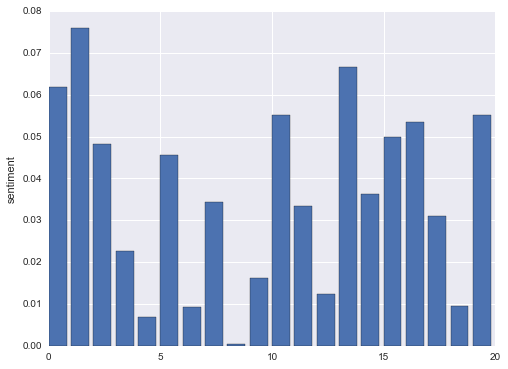

In [83]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [84]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment,cluster_20,cluster_3_syl,cluster_3no_syl,cluster_5
5576,"Kou-en listened with respectful attention, but...","[6, 8, 4, 10, 9, 3, 3, 4, 7, 2, 2, 5, 4, 2, 4,...",113,"[2, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",34.0,0.248333,10,2,2,3
5577,"Indeed, he explained it to me at such length b...","[6, 2, 9, 2, 2, 2, 2, 4, 6, 2, 3, 2, 4, 10, 6,...",101,"[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, ...",33.0,0.000000,3,0,0,3
5578,"""At least,"" I said sleepily, ""it would seem th...","[2, 5, 1, 4, 8, 2, 5, 4, 4, 2, 3, 3, 7, 5, 2, ...",123,"[1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, ...",39.0,0.100000,3,1,1,3
5579,"""Yes, brother of the Monastery called the Worl...","[3, 7, 2, 3, 9, 6, 3, 5, 6, 8, 2, 1, 6, 5, 9, ...",391,"[0, 2, 1, 1, 4, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, ...",126.0,0.080000,6,1,1,4
5580,)_,[],0,[],0.0,0.000000,0,0,0,0


In [85]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) - (.06 * (int(len(df_novel) - 1)))
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [86]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(0, 3):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:1904]
df_novel['total_char'][1904:3755]
df_novel['total_char'][3755:5569]


In [87]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
1904
0.0384531795584
1904
3755
0.0282796125241
3755
5569
0.0415558032737


In [88]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.03845318  0.02827961  0.0415558 ]


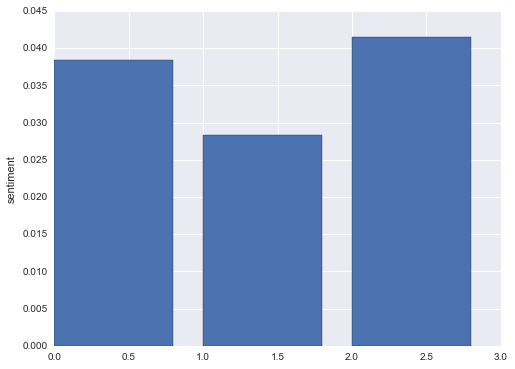

In [89]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers